# Kaggle titanic project

In [2]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store passenger IDs for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [17]:
print(test.info(), '\n')
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   P

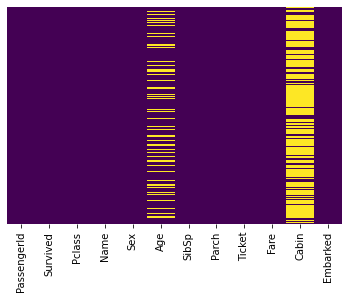

In [4]:
sns.heatmap(train.isnull(),cbar=False,yticklabels=False,cmap = 'viridis');

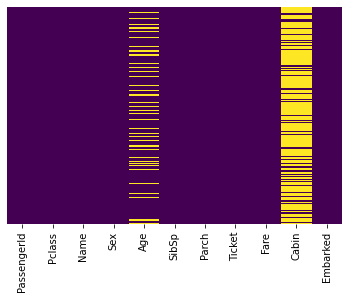

In [5]:
sns.heatmap(test.isnull(),cbar=False,yticklabels=False,cmap = 'viridis');

## Data transformation

In [18]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Finding out whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NaNs in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a new feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [20]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [21]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

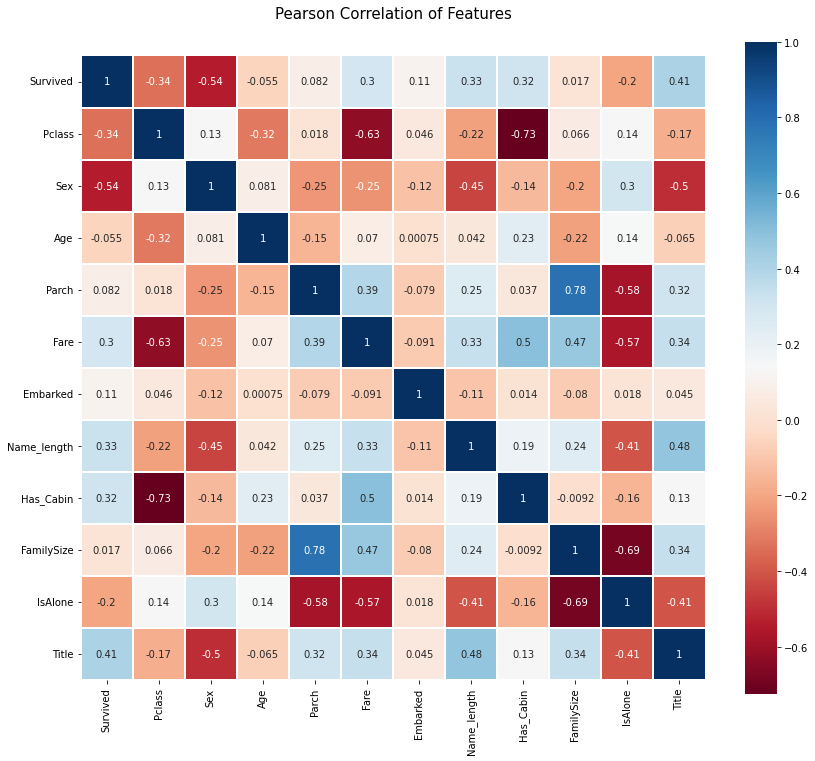

In [22]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

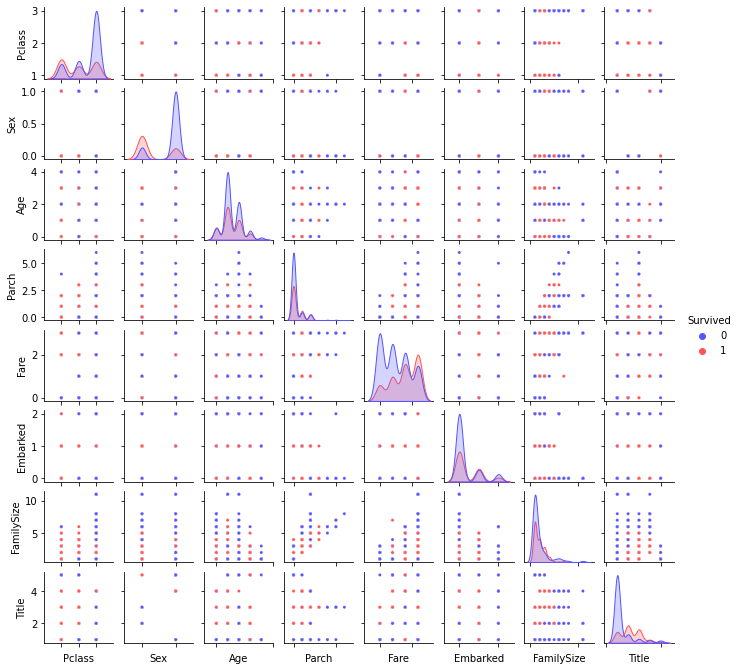

In [23]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.
We have got two datasets with new features. Let's proceed to modelling 
### Building a model

### 1.

In [27]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict




In [28]:
# Base algorithm parameters
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)} #LogisticRegression

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True) # quintuple cross-validation

# Splitting train data
train_data = train.drop(['Survived'], axis=1)
train_target = train['Survived']

data_train, data_valid, target_train, target_valid = train_test_split(train_data,
                                                                      train_target,
                                                                      random_state=0,
                                                                      test_size=.3)
# Initializing base algorithm
gbc = GradientBoostingClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)
svc = SVC(random_state=0)
lr = LogisticRegression(random_state=0)


models = [gbc, rfc, svc, lr]

### 2.
1. For each base model get the best paramethers via GridSearchCV (with cv=skf)
2. Then get predictions for validation data and derive accuracy scores


In [29]:
from sklearn.metrics import accuracy_score

gbc_grid = GridSearchCV(gbc, gbc_params, cv=skf)
gbc_grid_fit = gbc_grid.fit(data_train, target_train)
gbc_acc = accuracy_score(gbc_grid_fit.predict(data_valid), target_valid)
print(f'GBC best params: {gbc_grid.best_params_} \n Accuracy score: {gbc_acc} \n')

rfc_grid = GridSearchCV(rfc, rfc_params, cv=skf)
rfc_grid_fit = rfc_grid.fit(data_train, target_train)
rfc_acc = accuracy_score(rfc_grid_fit.predict(data_valid), target_valid)
print(f'RFC best params: {rfc_grid.best_params_} \n Accuracy score: {rfc_acc} \n')

svc_grid = GridSearchCV(svc, svc_params, cv=skf)
svc_grid_fit = svc_grid.fit(data_train, target_train)
svc_acc = accuracy_score(svc_grid_fit.predict(data_valid), target_valid)
print(f'SVC best params: {svc_grid.best_params_} \n Accuracy score: {svc_acc} \n')

lr_grid = GridSearchCV(lr, lr_params, cv=skf)
lr_grid_fit = lr_grid.fit(data_train, target_train)
lr_acc = accuracy_score(lr_grid_fit.predict(data_valid), target_valid)
print(f'LR best params: {lr_grid.best_params_} \n Accuracy score: {lr_acc} \n')

GBC best params: {'learning_rate': 0.1} 
 Accuracy score: 0.8134328358208955 

RFC best params: {'min_samples_leaf': 4, 'n_estimators': 50} 
 Accuracy score: 0.8395522388059702 

SVC best params: {'C': 0.1, 'kernel': 'linear'} 
 Accuracy score: 0.7947761194029851 

LR best params: {'C': 0.5} 
 Accuracy score: 0.8059701492537313 



### 3.
Tune the meta-algorithm with meta-features via GridSearchCV and parameters below. Deduce the best parameters.

In [30]:
xgb_params = {'n_estimators': [80],
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)
             }

In [31]:
models = [gbc_grid_fit, rfc_grid_fit, svc_grid_fit, lr_grid]
meta_mtrx = np.empty((data_valid.shape[0], len(models)))

for i, model in enumerate(models):
    meta_mtrx[:, i] = model.predict(data_valid)

In [ ]:
xgb = XGBClassifier(random_state=0)

xgb_grid = GridSearchCV(xgb, xgb_params, cv=skf)
xgb_grid_fit = xgb_grid.fit(meta_mtrx, target_valid)
xgb_grid_fit.best_params_

[14:11:10] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:10] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:11] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:11] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

### 4.
Using a fivefold cross-validation and each model's best parameters, build a stacking model. Make a meta-algorithm prediction.

In [32]:
from sklearn.model_selection import cross_val_predict

gbc_base = GradientBoostingClassifier(learning_rate=0.1, random_state=0)
rfc_base = RandomForestClassifier(min_samples_leaf=3, n_estimators=60, random_state=0)
svc_base = SVC(C=0.1, kernel='linear', random_state=0)
lr_base = LogisticRegression(C=0.6, random_state=0)
meta_alg = XGBClassifier(n_estimators=80, eta=0.9, min_child_weight=1, subsample=0.9000000000000001, random_state=0) 

models = [gbc_base, rfc_base, svc_base, lr_base]
models_fit = []
meta_mtrx = np.empty((train_target.shape[0], len(models)))

for i, model in enumerate(models):
    meta_mtrx[:, i] = cross_val_predict(model, train_data, train_target, cv=5, method='predict')
    models_fit.append(model.fit(train_data, train_target))
    
meta_model = meta_alg.fit(meta_mtrx, train_target)

meta_mtrx_test = np.empty((test.shape[0], len(models_fit)))

for i, model in enumerate(models_fit):
     meta_mtrx_test[:, i] = model.predict(test)
        
meta_predict = meta_model.predict(meta_mtrx_test)

[12:27:34] WARNING: D:\Build\xgboost\xgboost-1.5.1.git\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 5.
Submission form for Kaggle:

In [33]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)
    

In [ ]:
write_to_submission_file(meta_predict, PassengerId)

### 6.
Competition result

Score: 0.76555
